#### A3.4 Classification

* 3.4 Uploaded new version of `A3grader.zip`.  The only change is that any number of correct that is greater than 48 is now graded as correct.
* 3.3 Changed `_objective_to_actual` back to simpler form.  Source is later in this notebook.  An error in code cell [43] has been corrected, but this does not affect the output of any other code cells. Also, a simple error in `optimizers.py` has been fixed so download `A3code.zip` again and unzip it.  And `A3grader.zip` is finally available.
* 3.2: Added the code for `_objective_to_actual` and more calls to set the random number seed each place it is needed to help you test your code. Also made small change in `neuralnetworks.py`, so please download `A3code.zip` again and unzip it.
* 3.1: Replaced example output from `python neuralnetworks.py` with correct values.  Added call to `np.random.seed` to set the seed value for the random number generator so your example runs will produce same output as the output included here.

*by Chuck Anderson for [CS545: Machine Learning](https://www.cs.colostate.edu/~anderson/cs545) at Colorado State University*

In this assignment you will define a new class named `NeuralNetworkClassifier` that extends the given class `NeuralNetwork`.  Your new class will reuse most of the code in its parent class, but you will have to define the parts of the code that differ to allow the network to do classification. 

To learn a bit about how to call methods in a parent class, take a look at this
[introduction to inheritance](https://realpython.com/python-super/) and examples of using `super()`.

Start by downloading [A3code.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3code.zip).  Unzip this and you should see these files:

*  `mlutilities.py`
*  `neuralnetworks.py`
*  `optimizers.py`

If you just run `neuralnetworks.py` you should see the following result. Your times will be different but the RMSE values should be very close to these.

```
$ python neuralnetworks.py 
Called np.random.seed(42)
scg  [] use_torch=False RMSE 7.266 took 0.001 seconds
scg  [5, 5] use_torch=False RMSE 0.809 took 0.100 seconds
sgd  [5, 5] use_torch=False RMSE 0.635 took 0.035 seconds
adam [5, 5] use_torch=False RMSE 0.196 took 0.037 seconds
scg  [] use_torch=True RMSE 7.266 took 2.429 seconds
scg  [5, 5] use_torch=True RMSE 0.220 took 6.137 seconds
sgd  [5, 5] use_torch=True RMSE 0.757 took 1.983 seconds
adam [5, 5] use_torch=True RMSE 0.240 took 1.947 seconds


```

# Changes Required

The first line of your new class definition will be

```
   .
   .
   .
import neuralnetworks as nn

class NeuralNetworkClassifier(nn.NeuralNetwork):
   .
   .
   .```

Only one change is required in the arguments for all functions, and the change is in the constructor arguments.  The constructor must be dchanged from how it is defined in the `NeuralNetwork` class
```
    def __init__(self, n_inputs, n_hiddens_list, n_outputs, use_torch=False):
```
to
```
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):
```
where ```classes``` is just a list of class integer names, like `[1, 2, 3]`.

The only methods that you will have to include in your new `NeuralNetworkClassifier` are
```
__init__
__repr__
_standardizeT
_unstandardizeT
_forward_pass
_objectiveF
_objective_to_actual
train
use
```

You may introduce new methods that these use, such as
```
_make_indicator_variables```

## Definition of `NeuralNetworkClassifier`

Here is a start at defining your new class.  This bit of code includes everything you will need in the constructor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn

# Extend the nn.NeuralNetwork class to reuse much of its implementation
# Only those methods that must be altered to do classification are defined in NeuralNetworkClassifier

class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        
        self.classes = np.array(classes) # to allow argmax in use()
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
        else:
            self.log = np.log
            self.exp = np.exp
        

# insert the rest of your class methods here.

## Example Tests

Here are some tests of your code and what the results should show.  First the original `NeuralNetwork` class methods are called then the new ones you define in `NeuralNetworkClassifier`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks as nn

Here is some toy data.  Input samples have two components, and all values are from 0 to 1.9.  Two targets are defined. The first is the square of of the first input component.  The second is the sine of the second component.

In [2]:
X = np.arange(20).reshape((10, 2)) * 0.1
T = np.hstack((X[:, 0:1]**2, np.sin(X[:, 1:2])))
X.shape, T.shape

((10, 2), (10, 2))

In [3]:
X

array([[0. , 0.1],
       [0.2, 0.3],
       [0.4, 0.5],
       [0.6, 0.7],
       [0.8, 0.9],
       [1. , 1.1],
       [1.2, 1.3],
       [1.4, 1.5],
       [1.6, 1.7],
       [1.8, 1.9]])

In [4]:
T

array([[0.        , 0.09983342],
       [0.04      , 0.29552021],
       [0.16      , 0.47942554],
       [0.36      , 0.64421769],
       [0.64      , 0.78332691],
       [1.        , 0.89120736],
       [1.44      , 0.96355819],
       [1.96      , 0.99749499],
       [2.56      , 0.99166481],
       [3.24      , 0.94630009]])

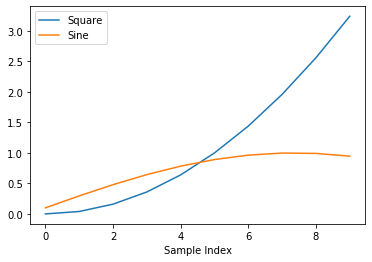

In [5]:
plt.plot(T)
plt.xlabel('Sample Index')
plt.legend(['Square', 'Sine']);

In [6]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)  Network is not trained.

In [7]:
nnet.train(X, T, 50, method='scg')
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0948 seconds. Final objective value is 0.074

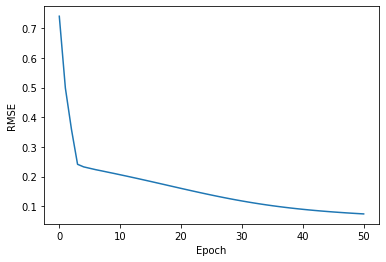

In [8]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

In [9]:
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0948 seconds. Final objective value is 0.074

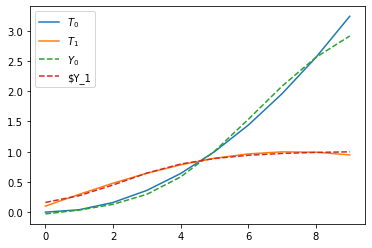

In [10]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Now with SGD.

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0145 seconds. Final objective value is 0.212


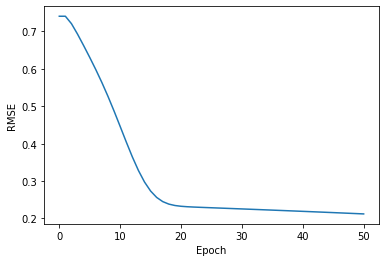

In [11]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='sgd', learning_rate=0.1, momentum_rate=0.5)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

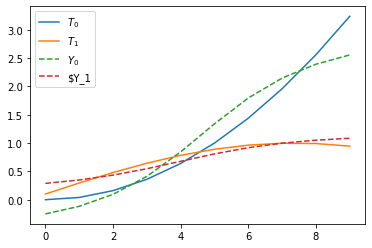

In [12]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

and with Adam

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0185 seconds. Final objective value is 0.037


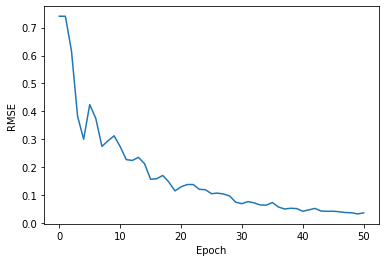

In [13]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

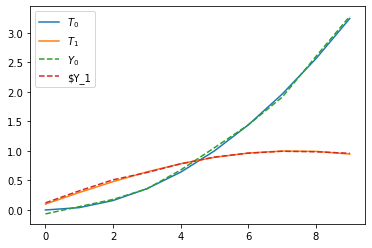

In [14]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

To test the use of pytorch, add `use_torch=True` to the constructor.

NeuralNetwork(2, [10, 10], 2, use_torch=True)
   Network was trained for 50 epochs that took 0.2238 seconds. Final objective value is 0.036


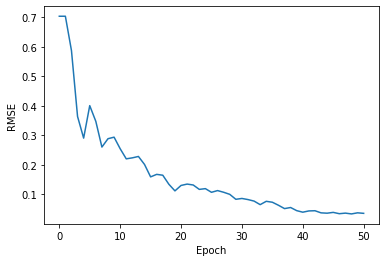

In [15]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2, use_torch=True)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

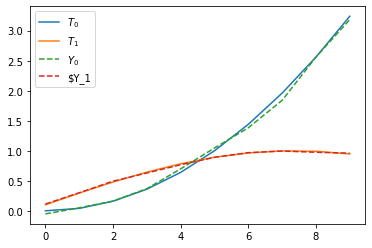

In [16]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Now for some tests on the individual new class methods.  First we create some toy classification data.  Each sample has two inputs, randomly chosen from integers 0, 1, and 2.  Target class is 1 if the two input samples are equal, 0 if they are not.

In [17]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [37]:
print(f'{np.sum(T==0)} not equal, {np.sum(T==1)} equal')

8 not equal, 12 equal


In [47]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=False)  Network is not trained.

We will not be standardizing targets T for this network, so we must redefine the two relevant functions so they just return their argument.

In [48]:
nnet_new._standardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [49]:
nnet_new._unstandardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

The standardization functions from the parent class will be available to us.

In [50]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

In this test of `_forward_pass` your results will differ, because they depend on the randomly-initialized weight values.

In [51]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[0.55163905, 0.44836095],
       [0.52855705, 0.47144295],
       [0.59590952, 0.40409048],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539],
       [0.57163885, 0.42836115],
       [0.56395347, 0.43604653],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.59746461, 0.40253539],
       [0.52855705, 0.47144295],
       [0.56007003, 0.43992997],
       [0.56395347, 0.43604653],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539]])

In [1]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = np.hstack((1 - T, T))  # this only works for this particular two-class toy data

nnet_new._objectiveF(w, X, T_indicator_vars)

NameError: name 'nnet_new' is not defined

The conversion from objective function, which is being minimized, to the "mean" likelihood of the data that we wish to maximize, is done by your new definition of `_objective_to_actual`.  This function is given as its argument the output from `_objectiveF` which is the negative mean log likelihood.  It should convert this to just likelihood. Do this by removing the operations in reverse order.  This is confusing a number of you, so I will give you the correct code here.


    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)

Now, for the workhorses, the functions the user of your class will use.

In [44]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=False)
   Network was trained for 66 epochs that took 0.0417 seconds. Final objective value is 1.000

In [45]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((20, 1), (20, 2))

Let's plot target and predicted classes. Shift the predicted class a bit upward to we can see it.

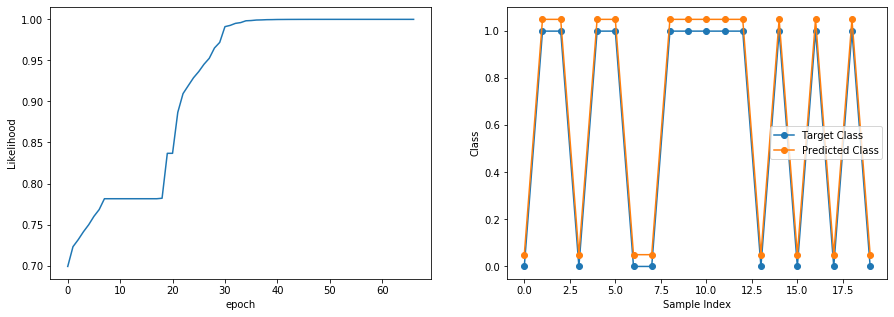

In [46]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

## Real Data Set

Now download a dataset for a classification problem from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).  Choose one you find interesting. Or you may use data you find elsewhere that you choose to work with.

Load the data into `numpy` arrays for `X` and `T`.  Use your `NeuralNetworkClassifier` to model the data.  Train on some or all of the data and calculate the number of samples that you correctly classify.  Compare the accuracy for several sizes of networks, numbers of epochs, and optimization algorithms.  Discuss what you find.  Are you able to model the data accurately?

# Grading

Download [A3grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.zip) and extract A3grader.py from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 80/80 if your functions are defined correctly. Other tests will be performed on your checked in notebook to make up the 80 execution points. The remaining 20 points will be based on the results you obtain from the classification data you download and your discussion of the results.

In [9]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Anderson-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetworkClassifier can learn to detect vowels when given
their ascii codes.

import numpy as np
ascii_code = list(range(65, 91)) + list(range(97, 123))
chars = [chr(n).lower() for n in ascii_code]
vowel = [c in ['a', 'e', 'i', 'o', 'u'] for c in chars]
X = np.array(ascii_code).reshape((-1, 1))
T = np.array(vowel).reshape((-1, 1))
classes = np.unique(T)

np.random.seed(120)
nnet = NeuralNetworkClassifier(X.shape[1], [50, 20, 20], classes)
nnet.train(X, T, 10000, verbose=True)
Yc, Y = nnet.use(X)
n_correct = (Yc == T).sum()
print(f'{n_correct} out of {T.shape[0]} samples, or {n_correct/T.shape[0]*100:.2f} percent.')
SCG: Iteration 1000 ObjectiveF=0.79791 Scale=1.000e-15 Seconds=1.187
SCG: Iteration 2000 ObjectiveF=0.80867 Scale=1

# Extra Credit

1. For the data set you have downloaded, randomly partition the data into about 80% for training and 20% for testing.  Discuss the percent of samples correctly classified for train and test partitions and how variations in netowrk size, epochs, and optimization algorithm effect the results.
2. Develop a new version of `optimizers.py`, `neuralnetworks.py` and your `NeuralNetworkClassifier` class that will run on a GPU using pytorch.  Add a keyword argument where neded called `use_gpu` that can be set to `True` to run on GPU.